In [6]:
from tqdm import tqdm
from torchvision import transforms
from PIL import Image, ImageChops
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [5]:
crop_size = 500
def resize_image_limit(img, max_width, max_height):
    """
    img - PIL.Image object
    max_width - maximum width allowed
    max_height - maximum height allowed

    This function rescale image by keeping its shape

    Reshape the image based on the shortest edge
    """
    if img.size[1] < img.size[0]:
        if img.size[1] > max_height:
            y = max_height
            x = max_height * (img.size[0] / img.size[1])
    elif img.size[0] <= img.size[1]:
        if img.size[0] > max_width:
            x = max_width
            y = max_width * (img.size[1] / img.size[0])
    else:
        return img
    p = transforms.Compose([transforms.Resize([round(y), round(x)])])
    return p(img)

def is_greyscale(im):
    if im.mode not in ("L", "RGB"):
        raise ValueError("Unsupported image mode")

    if im.mode == "RGB":
        rgb = im.split()
        if ImageChops.difference(rgb[0], rgb[1]).getextrema()[1]!=0:
            return False
        if ImageChops.difference(rgb[0], rgb[2]).getextrema()[1]!=0:
            return True
    return True

(2214, 1974)
The image is greyscale.


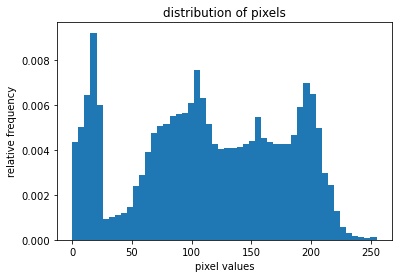

In [5]:
# img = Image.open('Data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
img = Image.open('../Pneumonia_classification_data/chest_xray/train/NORMAL/IM-0225-0001.jpeg')
print(img.size)
if is_greyscale(img):
    print(f'The image is greyscale.')
    img_np = np.array(img)
    # Plot image pixel values in histogram
    plt.hist(img_np.ravel(), bins=50, density=True)
    plt.xlabel("pixel values")
    plt.ylabel("relative frequency")
    plt.title("distribution of pixels")

Text(0.5, 1.0, 'distribution of pixels')

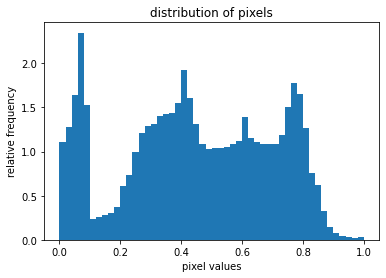

In [6]:
# Normalize the image pixel value range from (0, 256) to (0, 1)
transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img)
img_np = np.array(img_tensor)
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [7]:
dir = r'../Pneumonia_classification_data/chest_xray'

list_size_not_norm = []
min_width = 99999
min_height = 99999
for root, dirs, files in os.walk(dir):
    for name in files:
        filepath = root + os.sep + name
        if filepath.endswith(".jpeg"):
            img = Image.open(filepath)
            if img.size[0] < img.size[1]:
                list_size_not_norm.append([filepath, img.size[0], img.size[1]])
            if img.size[0] < min_width:
                min_width = img.size[0]
            if img.size[1] < min_height:
                min_height = img.size[1]

KeyboardInterrupt: 

In [8]:
for root, dirs, files in os.walk(dir):
    print(root)

../Pneumonia_classification_data/chest_xray
../Pneumonia_classification_data/chest_xray\test
../Pneumonia_classification_data/chest_xray\test\NORMAL
../Pneumonia_classification_data/chest_xray\test\PNEUMONIA
../Pneumonia_classification_data/chest_xray\train
../Pneumonia_classification_data/chest_xray\train\NORMAL
../Pneumonia_classification_data/chest_xray\train\PNEUMONIA
../Pneumonia_classification_data/chest_xray\val
../Pneumonia_classification_data/chest_xray\val\NORMAL
../Pneumonia_classification_data/chest_xray\val\PNEUMONIA


In [18]:
print(list_size_not_norm)

[['Data/chest_xray\\test\\NORMAL\\IM-0041-0001.jpeg', 2022, 2071], ['Data/chest_xray\\test\\NORMAL\\IM-0103-0001.jpeg', 1970, 2085], ['Data/chest_xray\\test\\NORMAL\\NORMAL2-IM-0019-0001.jpeg', 2043, 2087], ['Data/chest_xray\\test\\NORMAL\\NORMAL2-IM-0030-0001.jpeg', 2517, 2713], ['Data/chest_xray\\train\\NORMAL\\IM-0140-0001.jpeg', 1156, 1237], ['Data/chest_xray\\train\\NORMAL\\IM-0172-0001.jpeg', 1876, 1893], ['Data/chest_xray\\train\\NORMAL\\IM-0371-0001.jpeg', 2024, 2036], ['Data/chest_xray\\train\\NORMAL\\IM-0413-0001.jpeg', 2318, 2411], ['Data/chest_xray\\train\\NORMAL\\IM-0501-0001.jpeg', 1870, 1905], ['Data/chest_xray\\train\\NORMAL\\IM-0581-0001.jpeg', 1338, 1433], ['Data/chest_xray\\train\\NORMAL\\IM-0595-0001.jpeg', 1924, 2102], ['Data/chest_xray\\train\\NORMAL\\IM-0608-0001-0002.jpeg', 1580, 1604], ['Data/chest_xray\\train\\NORMAL\\IM-0660-0001-0002.jpeg', 1654, 1688], ['Data/chest_xray\\train\\NORMAL\\NORMAL2-IM-0441-0001.jpeg', 2288, 2363], ['Data/chest_xray\\train\\NORMA

In [9]:
print(f'Picture minimum width: {min_width:.1f}, minimum height {min_height:.1f}')

Picture minimum width: 824.0, minimum height 424.0


Text(0, 0.5, 'Height (Pixels)')

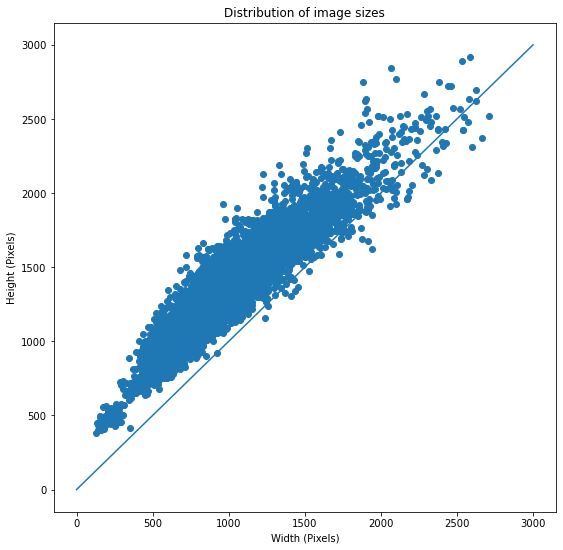

In [10]:
dir = r'../Pneumonia_classification_data/chest_xray'
widths = []
heights = []
shapes = []
for root, dirs, files in os.walk(dir):
    for name in files:
        filepath = root + os.sep + name
        if filepath.endswith('.jpeg'):
            img = Image.open(filepath)
            widths.append(img.size[0])
            heights.append(img.size[1])
plt.figure(figsize=(9,9))
plt.scatter(heights, widths)
x = np.linspace(0, 3000, 10)
plt.plot(x, x, linestyle='solid')  # Create a boundary line to determine landscape or portrait images
plt.title("Distribution of image sizes")
plt.xlabel('Width (Pixels)')
plt.ylabel('Height (Pixels)')

Size of image before crop (738, 500)


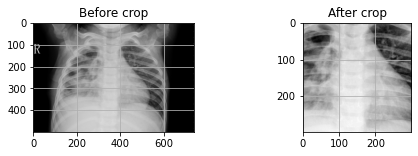

In [11]:
new_img = resize_image_limit(img, 500, 500)
print(f'Size of image before crop {new_img.size}')
fig, imgs = plt.subplots(1, 2, figsize=(8,2))
imgs[0].imshow(new_img, cmap='gray')
imgs[0].set_title('Before crop')
imgs[0].grid(True)
crop_img = transforms.CenterCrop(size=300)(new_img)
imgs[1].imshow(crop_img, cmap='gray')
imgs[1].set_title('After crop')
imgs[1].grid(True)

In [12]:
dir = r'../Pneumonia_classification_data/chest_xray'
limit_width = 500
limit_height = 500
crop_size = 500
reshaped_dir = rf'../Pneumonia_classification_data/reshape_{crop_size}'
reshape_image = False

if reshape_image:
    for root, dirs, files in tqdm(os.walk(dir)):
        for name in files:
            filepath = root + os.sep + name
            if name.endswith('.jpeg'):
                img = Image.open(filepath)
                if img.size[0] > limit_width and img.size[1] > limit_height:  # skip if the image is too small
                    # Resize and Crop the image
                    img = resize_image_limit(Image.open(filepath), limit_width, limit_height)
                    img = transforms.CenterCrop(size=crop_size)(img)
                    # Find destination folder
                    resh_root = root.replace(dir, reshaped_dir)
                    if not os.path.exists(resh_root):
                        os.makedirs(resh_root)
                    resh_filepath = resh_root + os.sep + name
                    # Save image
                    print(f'Saving {resh_filepath}, width: {img.size[0]}, height: {img.size[1]}')
                    img.save(resh_filepath)

Size of this image is :(500, 500)


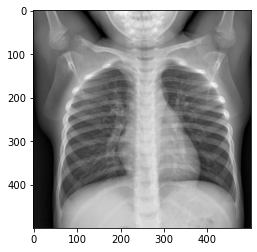

In [15]:
# Check the size of one image

reshaped_dir = rf'../Pneumonia_classification_data/reshape_{crop_size}'
image_path = r'train/NORMAL/IM-0225-0001.jpeg'
file_path = os.path.join(reshaped_dir, image_path)

img = Image.open(file_path)
print(f'Size of this image is :{img.size}')
plt.imshow(img, cmap='gray')

In [8]:
# Show classes names and value
data_dir = rf'../Pneumonia_classification_data/reshape_{crop_size}'
test_dir = os.path.join(data_dir, 'test')
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor()])
dataset_test = datasets.ImageFolder(test_dir, transform=transform)

print(dataset_test.classes)
print(dataset_test.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


torch.Size([4, 1, 500, 500])
The answer of images are tensor([0, 1, 1, 0])


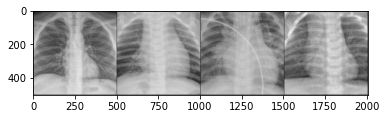

In [12]:
# Check loaded data samples
batch_size = 4
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
images, labels = next(iter(loader_test))
print(images.shape)

plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0))
print(f'The answer of images are {labels}')

In [21]:
# Load a batch of sample images, to verify the network connections
conv1 = nn.Conv2d(1, 6, 5)
pool = nn.MaxPool2d(4, 4)
conv2 = nn.Conv2d(6, 16, 5)
x = conv1(images)
print(f'Shape of Conv NN Layer 1 {x.shape}')
x = pool(F.relu(x))
print(f'Shape of Layer after pool {x.shape}')
conv2.in_channels = 3
conv2.out_channels = 10
x = conv2(x)
print(f'Shape of Conv NN Layer 2 {x.shape}')
x = pool(F.relu(x))
print(f'Shape of Layer after pool {x.shape}')
# x = conv3(x)
# print(f'Shape of Conv NN Layer 3 {x.shape}')
# x = pool(F.relu(x))
# print(f'Shape of Layer after pool {x.shape}')

Shape of Conv NN Layer 1 torch.Size([4, 6, 496, 496])
Shape of Layer after pool torch.Size([4, 6, 124, 124])
Shape of Conv NN Layer 2 torch.Size([4, 16, 120, 120])
Shape of Layer after pool torch.Size([4, 16, 30, 30])


In [1]:
import torch
import torch.nn as nn
class ConvolutionalNeuralNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 3: colors - R G B, 6: output layer size, 5: convolution kernel size
        self.pool = nn.MaxPool2d(4, 4)  #4: Pool size, 4: Stride size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*30*30, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

        self.model_feature_learning = torch.nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.pool,
            self.conv2,
            nn.ReLU(),
            self.pool
        )

        self.model_classification = torch.nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
            self.fc3
        )

        self.fc1_size_known = False


    def forward(self, x):  # n: number samples in a batch.
        # Start with n, 3, 32, 32
        x = self.model_feature_learning(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.model_classification(x)
        return x


# Use local GPU for CNN models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = ConvolutionalNeuralNet()
x = model.model_classification(images)
print(f'Shape of layer after classification layers {x.shape}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2000x500 and 14400x120)